In [1]:
import pandas as pd

In [443]:
#filename = 'D:\\Backup\\ISB CBA\\Capstone\\summary data\\ethos_transaction_summary_23-05-2020.csv'

#data=pd.read_csv(filename)
#d={'quantity':'count','sales_quantity':'sum','purchase_quantity':'sum','transfer_quantity':'sum'}
#chunksize = 10 ** 5
#rows=0
#df = pd.DataFrame()
#for chunk in pd.read_csv(filename, chunksize=chunksize):
# 
#    a=chunk.fillna(0).groupby(['region']).agg(d)
#    df=df.add(a, fill_value=0)
#    
#    rows+=chunk.shape[0]
#    print (rows)

In [2]:
filename = 'D:\\Backup\\ISB CBA\\Capstone\\summary data\\ethos_transaction_summary_23-05-2020.csv'

data=pd.read_csv(filename)
d={'quantity':'count','sales_quantity':'sum','purchase_quantity':'sum','transfer_quantity':'sum'}
chunksize = 10 ** 5
rows=0
df_north = pd.DataFrame()
for chunk in pd.read_csv(filename, chunksize=chunksize):
 
    n=chunk[chunk['region']=='North']
    df_north=pd.concat([df_north,n])
    rows+=chunk.shape[0]
    #print (rows)

In [4]:
#df.loc['Total']= df.sum()
#df.to_excel('D:\\Backup\\ISB CBA\\Capstone\\state.xlsx')
#chunk.to_csv('D:\\Backup\\ISB CBA\\Capstone\\chunk.csv')

In [3]:
df_north.shape

(2408346, 50)

In [4]:
#d={'quantity':'count','sales_quantity':'sum','purchase_quantity':'sum','transfer_quantity':'sum'}
#state=df_north.fillna(0).groupby(['state']).agg(d)
#state.loc['Total']=state.sum()
#state

In [5]:
df_north.columns

Index(['location_code', 'item_no', 'week', 'closing_date', 'brand',
       'department', 'quantity', 'purchase_quantity', 'transfer_quantity',
       'sales_quantity', 'purchase_cost_amount', 'purchase_mrp',
       'purchase_date', 'stock_prevailing_mrp', 'state', 'region', 'store_in',
       'product_group_code', 'transfer_cost_amount', 'transfer_mrp',
       'sales_department', 'days_to_sell', 'num_of_customers', 'sales_price',
       'total_price', 'line_discount', 'crm_line_discount', 'discount', 'tax',
       'cost', 'billing', 'contribution', 'trade_incentive',
       'trade_incentive_value', 'total_contribution', 'store_type',
       'store_location', 'city_type', 'case_size', 'case_size_range', 'gender',
       'movement', 'material', 'dial_color', 'strap_type', 'strap_color',
       'precious_stone', 'glass', 'case_shape', 'watch_type'],
      dtype='object')

In [6]:
df_north['available']=df_north.fillna(0)['quantity']+df_north.fillna(0)['purchase_quantity']+df_north.fillna(0)['transfer_quantity']
df_north['week_no'] = df_north['week'].str.slice(0, 3)
df_north['year'] = df_north['week'].str.slice(4,)

In [7]:
col=['location_code', 'item_no', 'brand','stock_prevailing_mrp', 'state', 'region','store_type',
                       'store_location', 'city_type', 'case_size', 'case_size_range', 'gender',
                        'movement', 'material', 'dial_color', 'strap_type', 'strap_color',
                        'precious_stone', 'glass', 'case_shape', 'watch_type', 'available',
                        'week_no', 'year','sales_quantity']

df_north_final=df_north.loc[:,col]
df_north_final.fillna(0, inplace=True)

df_north_final['item_no']=df_north_final['item_no'].astype(str)
df_north_final['case_size']=df_north_final['case_size'].astype(str)
df_north_final['case_shape']=df_north_final['case_shape'].astype(str)

In [8]:
#len(df_north_final['case_shape'].value_counts().index[13])
#len(df_north_final['case_shape'].value_counts().index[2])
#df_north_final['case_shape'][df_north_final['case_shape']=='0']

In [9]:
def pareto(cols):
    lst=[]
    for col in cols:
                
        series=df_north_final.fillna(0).groupby([col]).agg({'stock_prevailing_mrp':'sum'}).sort_values('stock_prevailing_mrp',ascending=False)
        mask=series.cumsum()/series.sum()>0.8 
        #nos=mask.value_counts()[1]
        mask=mask.iloc[:,0]
        levels=len(df_north_final[col].unique())
        if levels>=10:
            df_north_final[col] = np.where(df_north_final[col].isin(series[mask].index),'Other',df_north_final[col])         
        new_levels=len(df_north_final[col].unique())

        freq=df_north_final[col].value_counts()/df_north_final[col].value_counts().sum()*100
        freq=freq.round(2)

        sale_qty=df_north_final.groupby([col]).agg({'sales_quantity':'sum'}).sort_values('sales_quantity',ascending=False)
        sale_qty=sale_qty/sale_qty.sum()*100
        sale_qty=sale_qty.round(2)
        try:
            Other_Sales_Qty=sale_qty['sales_quantity']['Other']
        except:
            Other_Sales_Qty=0
        
        mrp=df_north_final.groupby([col]).agg({'stock_prevailing_mrp':'sum'}).sort_values('stock_prevailing_mrp',ascending=False)
        mrp=mrp/mrp.sum()*100
        mrp=mrp.round(2)
        try:
            Other_MRP=mrp['stock_prevailing_mrp']['Other']
        except:
            Other_MRP=0
        
        #comparison=mrp.merge(sale_qty, left_index=True, right_index=True)
        lst.append([col.upper(),levels, new_levels,Other_MRP,Other_Sales_Qty])
        #print ("%s-Originally %d levels,combined %d levels into 'Other'.New Levels %d.By MRP,Other is %2.1f and by sale qty others is %2.1f"%(col.upper(),levels, levels-new_levels, new_levels,mrp['stock_prevailing_mrp']['Other'],sale_qty['sales_quantity']['Other']))
    
    cols=['Feature', 'Orig Levels', 'New Levels', 'Other%(MRP)', 'Other%(Sales Qty)']
    df = pd.DataFrame(lst, columns=cols)
    df=df.set_index("Feature")
    
    return df

In [10]:
#not doing a pareto on case_shape and movement
import numpy as np
cols=['brand','case_size', 'case_size_range', 'gender', 'material', 'dial_color', 'strap_type', 'strap_color','precious_stone', 'glass', 'watch_type']
pareto(cols)

,Orig Levels,New Levels,Other%(MRP),Other%(Sales Qty)
Feature,,,,
BRAND,108,22,20.51,46.86
CASE_SIZE,313,20,20.82,20.03
CASE_SIZE_RANGE,14,6,22.10,28.57
GENDER,4,4,0.00,0.00
MATERIAL,96,7,22.15,19.05
DIAL_COLOR,62,6,22.64,20.08
STRAP_TYPE,91,7,22.15,19.94
STRAP_COLOR,59,6,24.68,34.81
PRECIOUS_STONE,9,9,0.00,0.00


In [11]:
df_north_final.columns

Index(['location_code', 'item_no', 'brand', 'stock_prevailing_mrp', 'state',
       'region', 'store_type', 'store_location', 'city_type', 'case_size',
       'case_size_range', 'gender', 'movement', 'material', 'dial_color',
       'strap_type', 'strap_color', 'precious_stone', 'glass', 'case_shape',
       'watch_type', 'available', 'week_no', 'year', 'sales_quantity'],
      dtype='object')

In [12]:
df_north_final['state'].value_counts()

ST03    803447
ST02    501328
ST19    337932
ST13    253321
ST07    222973
ST15    171910
ST24    117435
Name: state, dtype: int64

In [13]:
df_st03=df_north_final[df_north_final['state']=='ST03']

In [14]:
cols=['brand','state','region', 'store_type', 'store_location', 'city_type', 'case_size',
       'case_size_range', 'gender', 'movement', 'material', 'dial_color',
       'strap_type', 'strap_color', 'precious_stone', 'glass', 'case_shape',
       'watch_type', 'week_no', 'year']
df_north_dummies=pd.get_dummies(data=df_north_final, columns=cols)
df_st03_dummies=pd.get_dummies(data=df_st03, columns=cols)

In [37]:
df_st03_dummies.shape

(803447, 199)

In [15]:
#!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [17]:
y=df_st03_dummies.loc[:, df_st03_dummies.columns == 'sales_quantity']
X=df_st03_dummies.drop(columns =['sales_quantity','location_code','item_no'])

In [18]:
#checking for duplicate column names
duplicate_columns = df_north_dummies.columns[df_north_dummies.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [19]:
#X,y=df_north_dummies.loc[:, df_north_dummies.columns != ['sales_quantity','location_code','item_no']],df_north_dummies.loc[:, df_north_dummies.columns == 'sales_quantity']
#X, y = df_north_final.iloc[:,:-1],df_north_final.iloc[:,-1]
data_matrix = xgb.DMatrix(data=X,label=y)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

In [22]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[19:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [23]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.300432


In [26]:
from sklearn.metrics import r2_score
r2_score(y_test,preds)

-0.3635757083365503

In [27]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[19:04:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:04:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:04:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.628652,0.044566,0.629706,0.099936
1,0.602519,0.046593,0.602882,0.104697
2,0.577101,0.044114,0.580055,0.109262
3,0.554404,0.046397,0.560652,0.113456
4,0.538614,0.047732,0.544446,0.117174


In [29]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.461445
Name: test-rmse-mean, dtype: float64


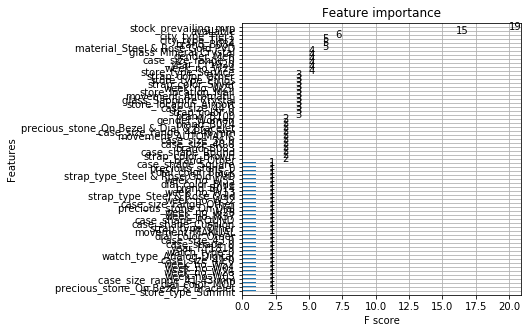

In [34]:
import matplotlib.pyplot as plt 
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()